# 9 비지도 학습
입력 정보만 사용하는 비지도 학습

# 9.1 2차원 입력 데이터
비지도 학습 문제는 클래스 데이터를 사용하지 않음

클러스터: 데이터 분포에서 비슷한 점끼리 분포로 나누어 할당하는 것

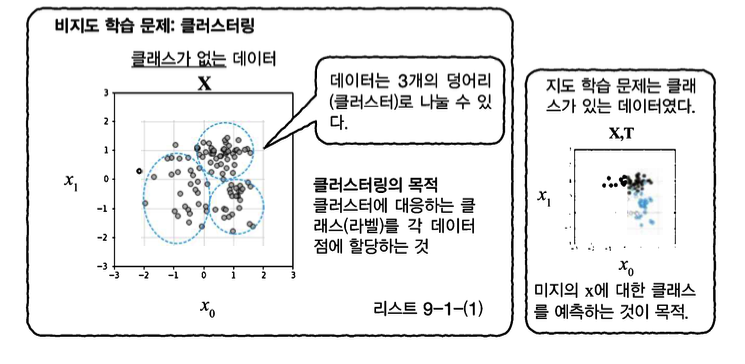

<ipython-input-2-b7f2aaefbfb8>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] + Mu[T3[n, :] == 1, k])


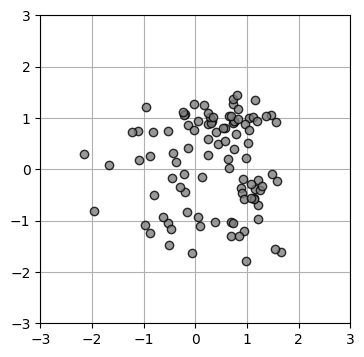

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype = np.uint8)
X  = np.zeros((N, 2))

X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']

Mu  = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi  = np.array([0.4, 0.8, 1]) # 누적 확률

for n in range(N) :
  wk = np.random.rand()

  for k in range(K) :
    if wk < Pi[k] :
      T3[n, k] = 1
      break
  for k in range(2) :
    X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] + Mu[T3[n, :] == 1, k])

def show_data(x) :
  plt.plot(x[:, 0], x[:, 1], linestyle = 'none', marker = 'o', markersize = 6, markeredgecolor = 'black', color = 'gray', alpha = 0.8)
  plt.grid(True)

plt.figure(1, figsize = (4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X = X, X_range0 = X_range0, X_range1 = X_range1)


K-means 기법과 가우시안 혼합 모델을 사용한 클러스터링을 학습

# 9.2 K-means 기법

# 9.2.1 K-means 기법의 개요

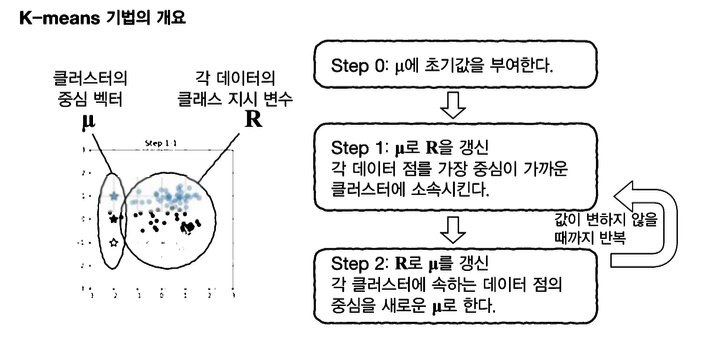

K-means, 가우시안 혼합 모델 모두 미리 분할할 클러스터의 수
$K$를 결정해야 함

K-means
- 클러스터의 중심 벡터 $\mu$: 클러스터의 중심 위치를 나타냄
- 클래스 지시 변수 **R**: 각 데이터 점이 어떤 클러스터인 지

- step0: 중심 벡터에 적절한 값 제공 -> 중심 잠정적 결정
- step1: 현 시점 중심 벡터를 바탕으로 클래스 지시 변수 결정
- step2: 현 시점에서 클래스 지시 변수로 중심 벡터 갱신

이후 step1,step2 반복 -> $\mu$, **R** 갱신
-> 양자의 값이 변화 x -> 종료

# 9.2.2 Step 0: 변수의 준비와 초기화
중심 벡터:

$\mu_k = [\mu_{k0},\mu_{k1}]$

입력: 2차원 -> 중심: 2차원

적당한 초기값 할당

클래스 지시 변수 R은 1, 0 데이터 $n$이 $k$에 속하는 경우,
속하지 않는 경우

one-hot-coding 상태로 나타내며

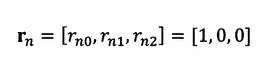

행렬로 나타내면

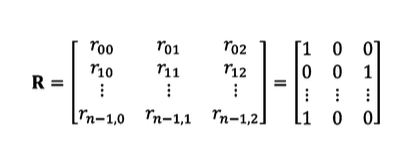

In [3]:
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype = int), np.zeros((N, 2), dtype = int)]

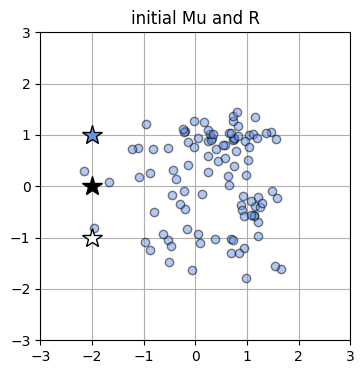

In [4]:
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포의 묘사
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1],
                 marker='o',
                 markerfacecolor=X_col[k], markeredgecolor='k',
                 markersize=6, alpha=0.5, linestyle='none')
        # 데이터의 평균을 "별표"로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=X_col[k], markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)

plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

# 9.2.3 Step 1: R의 갱신
**R**갱신 방법:

"각 데이터 점을 가장 중심이 가까운 클러스터에 넣는다."

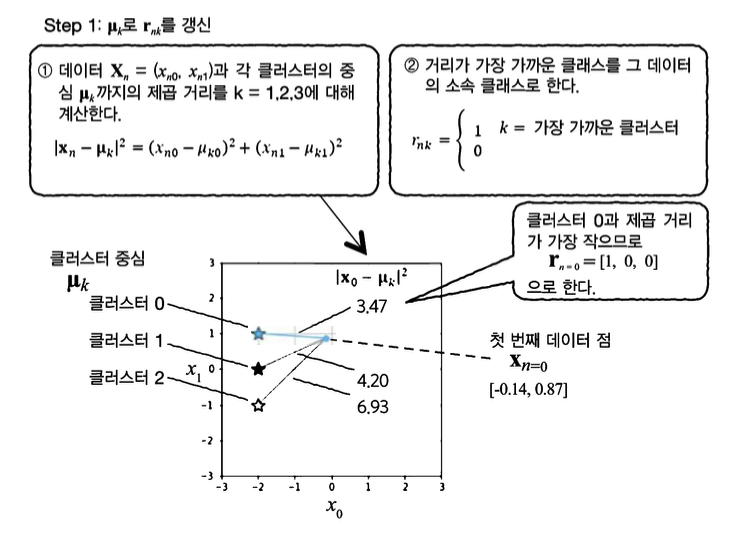

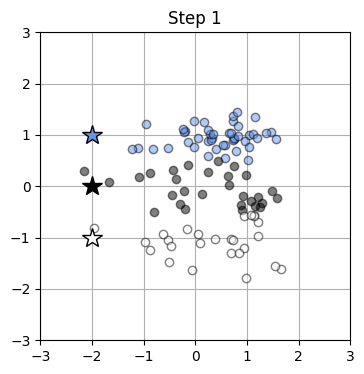

In [5]:
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2
        r[n, np.argmin(wk)] = 1
    return r

plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

# 9.2.4 Step 2: 𝜇의 갱신
𝜇갱신 방법:

"각 클러스터에 속하는 데이터 점의 중심을 새로운 𝜇로 한다."
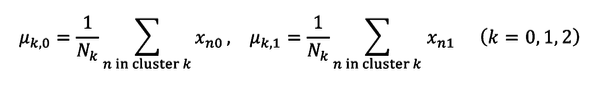

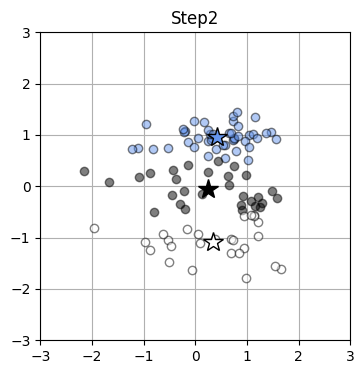

In [6]:
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu

plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

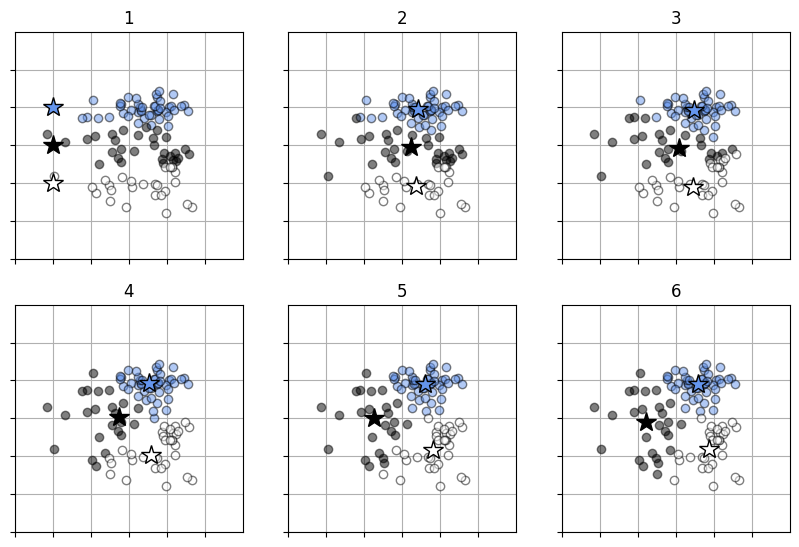

In [7]:
plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
max_it = 6 # 반복 횟수
for it in range(0, max_it):
    plt.subplot(2, 3, it + 1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    show_prm(X, R, Mu, X_col)
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

# 9.2.5 왜곡 척도
K-means 의 경우 데이터 점이 속한 클러스터의 중심까지의 제곱 거리를 전체 데이터로 합한 것이 목적함수에 대응하고, 왜곡 척도 distortion measure라고 함

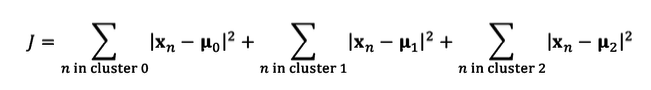

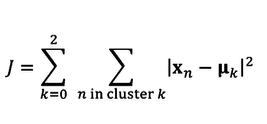

$r_{nk}$는 데이터 $n$이 속한 클러스터에서는 1, 속하지 않는 클러스터에서는 0이 되는 변수라는 사실을 이용해

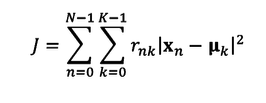

In [8]:
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원으로 제한하고 있다
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0])**2
                               + (x1[n] - mu[k, 1])**2)
    return J
# ---- test
# ---- Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


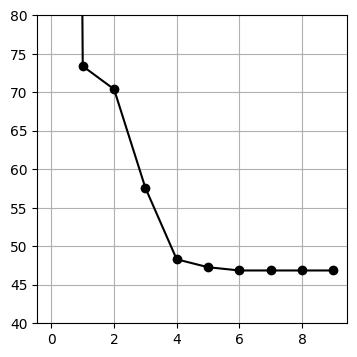

In [9]:
N=X.shape[0]
K=3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과를 넣는다
for it in range(0, max_it): # K-means 법
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

왜곡 척도에 대한 그림 step6에서 수렴.

K-means의 문제는 초기값에 의존성 존재.

초기값에 따라 결과가 달라질 수 있음

다양한 초기값에서 시작해 얻은 결과 중에 가장 왜곡 척도가 작은 결과를 사용하면 됨

# 9.3 가우시안 혼합 모델

# 9.3.1 확률적 클러스터링
K-means는 데이터 점을 반드시 클러스터에 할당 -> 클러스터 0의 중심에 있는 데이터, 클러스터 0 끝에 있는 데이터 동일한 클러스터에 할당됨

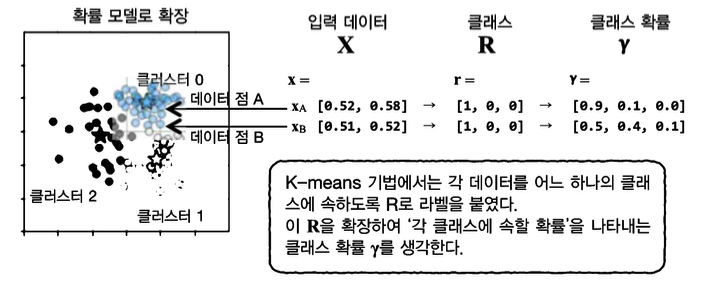

K-means 기법에 확률의 개념을 도입해 확장
클래스 변수를 다 더하면 1

관찰은 못했지만 데이터에 영향을 준 변수를 잠재 변수 또는 숨은 변수 Hidden variable이라 함

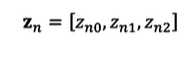

관찰할 수 없는 **Z**의 추정치가 $\gamma$이다.

**Z**는 0또는 1의 값을 갖지만 $\gamma$는 확률적인 추정값이므로 0~1의 실수 값을 취함.

이 $\gamma$는 부담률 responsibility라고 함

정리하면 확률적 클러스터링은 데이터의 배후에 숨어 있는 잠재 변수 **Z**를 확률적으로 $\gamma$으로 추정하는 것

# 9.3.2 가우시안 혼합 모델
부담률 $\gamma$를 구하기 위한 가우시안 혼합 모델 확률 모델

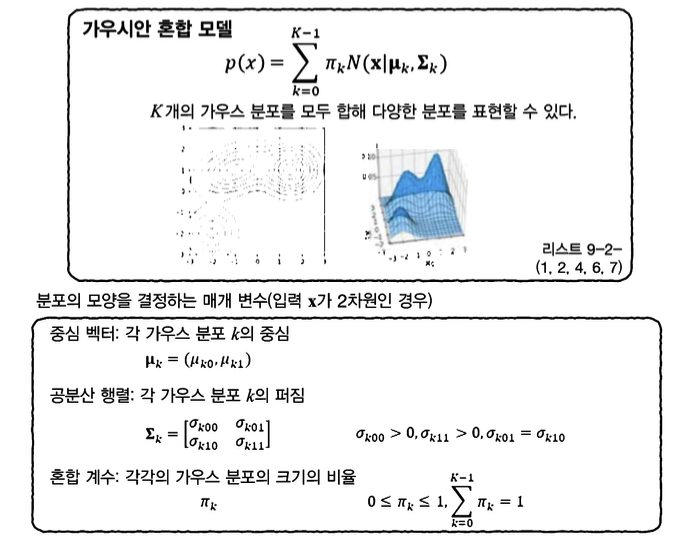

가우시안 혼합 모델은 2차원 가우스 함수 여러 개를 합친 것

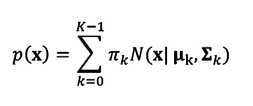

평군 공분산 행렬의 2차원 가우스 함수를 나타냄

서로 다른 평균과 공분산 행렬을 가진 2차원 가우스 함수가 $K$개 겹친 분포를 나타냄

In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [11]:
import numpy as np

wk = np.load('data_ch9.npz')
X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

In [14]:
#가우스 함수
def gauss(x, mu, sigma):
  N, D = x.shape
  c1 = 1 / (2 * np.pi)**(D / 2)
  c2 = 1 / (np.linalg.det(sigma)**(1 / 2))
  inv_sigma = np.linalg.inv(sigma)
  c3 = x - mu
  c4 = np.dot(c3, inv_sigma)
  c5 = np.zeros(N)
  for d in range(D):
      c5 = c5 + c4[:, d] * c3[:, d]
  p = c1 * c2 * np.exp(-c5 / 2)
  return p

In [15]:
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


In [16]:
def mixgauss(x, pi, mu, sigma):
  N, D = x.shape
  K = len(pi)
  p = np.zeros(N)
  for k in range(K):
    p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
  return p

In [17]:
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
# 혼합 가우스 등고선 표시
def show_contour_mixgauss(pi, mu, sigma):
  xn = 40 # 등고선 표시 해상도
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)
  x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
  f = mixgauss(x, pi, mu, sigma)
  f = f.reshape(xn, xn)
  f = f.T
  plt.contour(x0, x1, f, 10, colors='gray')


# 혼합 가우스 3D 표시
def show3d_mixgauss(ax, pi, mu, sigma):
  xn = 40 # 등고선 표시 해상도
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)
  x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
  f = mixgauss(x, pi, mu, sigma)
  f = f.reshape(xn, xn)
  f = f.T
  ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3,
                  color='blue', edgecolor='black')

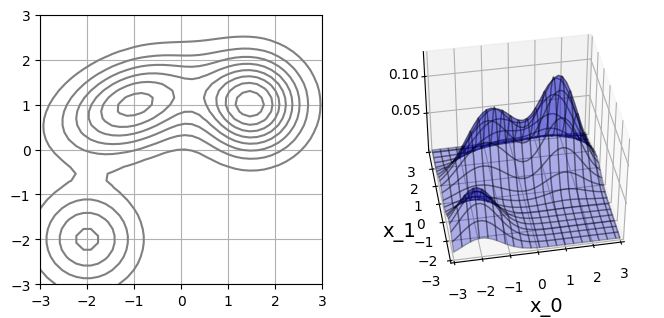

In [20]:
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array(
    [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])

Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)

Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('x_0', fontsize=14)
Ax.set_ylabel('x_1', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

# 9.3.3 EM 알고리즘의 개요
EM 알고리즘을 사용하여 가우시안 혼합 모델을 데이터에 피팅해보고,
부담률을 구하는 방법을 섫명

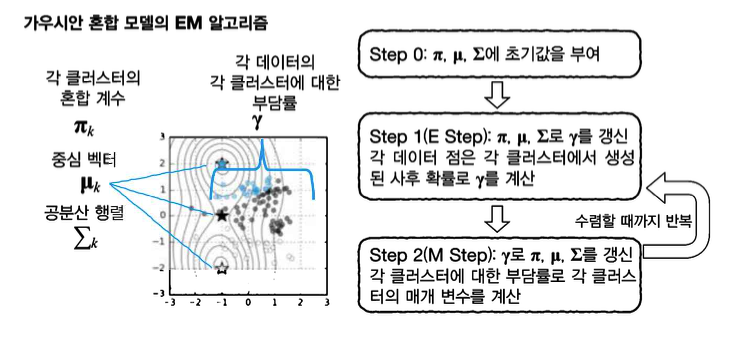

가우시안 혼합 모델은 중심 벡터 $\mu$, 공분산 행렬 $\sum$에 의해 각 클래스터의 확산 정도를 기술

알고리즘:
- step0: $\pi, \mu, \sum$ 초기화
- step1: 현시점의 $\pi, \mu, \sum$를 사용하여 $\gamma$ 구함 -> 이 step은 EM 알고리즘으로 E-step이라함
- step2: 현시점의 $\gamma$를 사용해 $\pi, \mu, \sum$를 구함 -> M step
- E step M step을 수렴까지 반복

# 9.3.4 Step 0: 변수의 준비 및 초기화

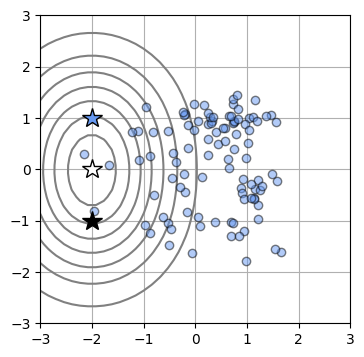

In [21]:
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]

X_col=np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])

def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col=gamma[n,0]*X_col[0]+gamma[n,1]*X_col[1]+gamma[n,2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o',
                 color=tuple(col), markeredgecolor='black',
                 markersize=6, alpha=0.5)
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=tuple(X_col[k]), markersize=15,
                 markeredgecolor='k', markeredgewidth=1)


    plt.grid(True)

plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

# 9.3.5 Step 1(E Step): 𝛾갱신
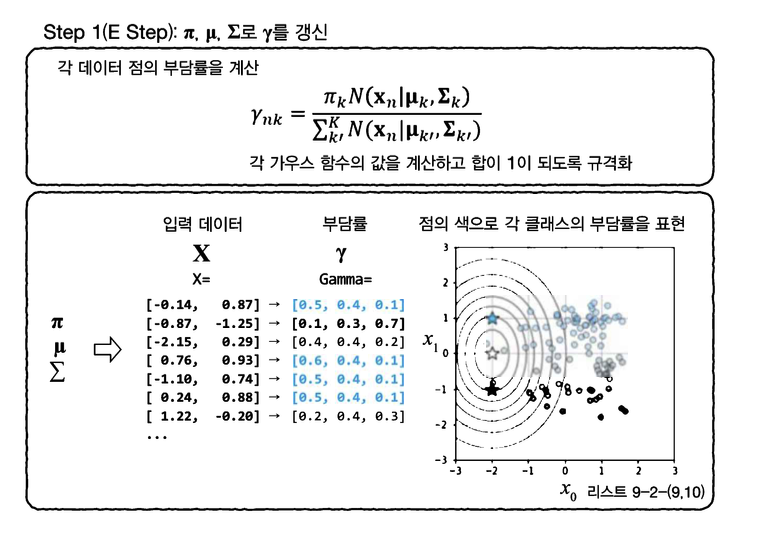

부담률 $\gamma$를 모든 $n$과 $k$에 대해 갱신

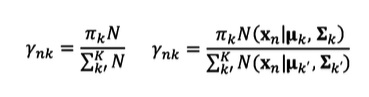

'가우스 함수의 값이 높을수록 부담률도 높아진다.'
는 직관적인 갱신 방법

In [22]:
def e_step_mixgauss(x, pi, mu, sigma):
  N, D = x.shape
  K = len(pi)
  y = np.zeros((N, K))
  for k in range(K):
    y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
  gamma = np.zeros((N, K))
  for n in range(N):
    wk = np.zeros(K)
    for k in range(K):
      wk[k] = pi[k] * y[n, k]
    gamma[n, :] = wk / np.sum(wk)
  return gamma

Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

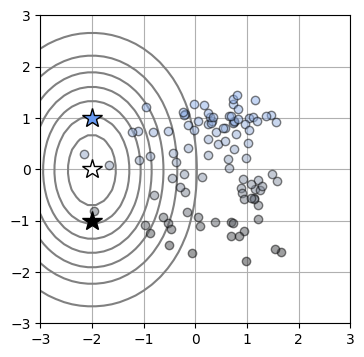

In [23]:
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

# 9.3.6 Step 2(M Step): 𝜋,𝜇,∑의 갱신
우선 각 클러스터에 대한 부담률으 합 $N_k$를 구함

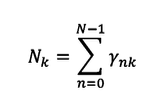

위 식을 바탕으로 혼합률 $\pi_k$를 갱신

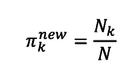

$N$ 은 전체 데이터 수 이므로 혼합률은 전체에 대한 클러스터 내 수의 비율이 되는, 적합한 갱신식

그리고 중심 벡터 $\mu_k$를 갱신

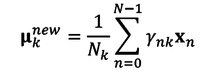

마지막으로 가우스의 공분산 행렬을 갱신

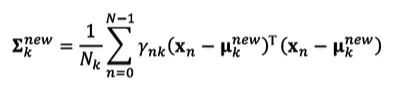

클러스터에 부담률의 가중치를 더한 데이터의 공분산 행렬을 구하는 것이며, 가우스 함수를 데이터에 피팅할 때의 공분산 행렬을 구하는 방법과 유사

In [24]:
def m_step_mixgauss(x, gamma):
  N, D = x.shape
  N, K = gamma.shape
  # pi를 계산
  pi = np.sum(gamma, axis=0) / N
  # mu을 계산
  mu = np.zeros((K, D))
  for k in range(K):
    for d in range(D):
      mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
  # sigma를 계산
  sigma = np.zeros((K, D, D))
  for k in range(K):
    for n in range(N):
      wk = x - mu[k, :]
      wk = wk[n, :, np.newaxis]
      sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
    sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
  return pi, mu, sigma
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

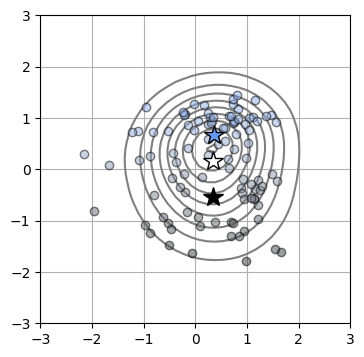

In [25]:
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

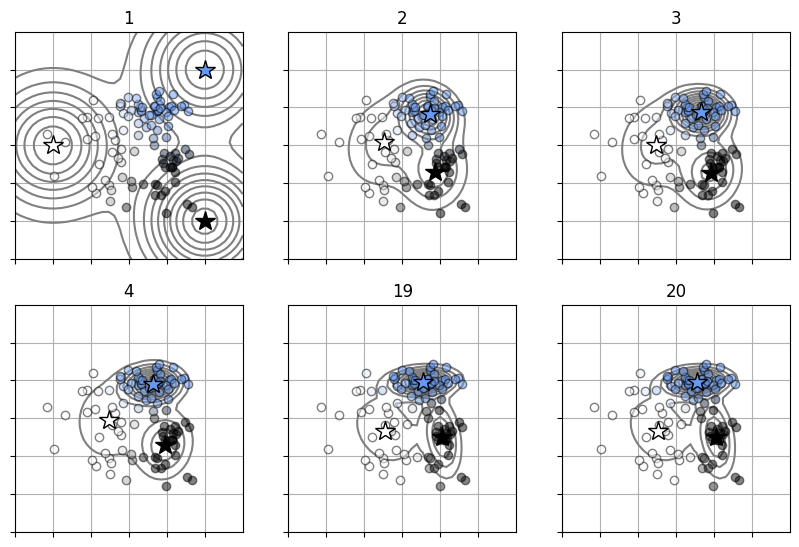

In [26]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수

i_subplot=1;
for it in range(0, max_it):
  Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
  if it<4 or it>17:
    plt.subplot(2, 3, i_subplot)
    show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    i_subplot=i_subplot+1
  Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

# 9.3.7 가능도
가우시안 혼합 모델은 데이터의 분포 $p(x)$를 나타내는 모델.
로지스틱 회귀 모델은 $p(t|x)$와 x에 대해 클래스의 확률을 나타내는 모델이었기 때문에, 클러스터링에서 취급하는 모델은 분류 문제에서 다룬 모델과는 다른 유형.
그리고 EM 알고리즘은 가우시안 혼합 모델이 입력 데이터 **X**의
분포에 맞게 매개 변수를 갱신하는 알고리즘.
입력 데이터가 조밀한 부분에 가우스 함수가 배치되어, 입력 데이터가
뛰엄뛰엄한 부분은 분포의 값이 낮도록 매개 변수가 조정되었음.
그 결과, '각 가우스 분포가 다른 클러스터를 나타낸' 것.

EM 알고리즘은 **X**가 생성된 확률(가능도)를 최적화 가장 높도록 매개변수가 갱신되고 있었음.

가능도나 로그 가능도를 최적화시킬 때는 극대화하기 때문에 -1을 곱하 음의 로그 가능도 오차 함수로 정의

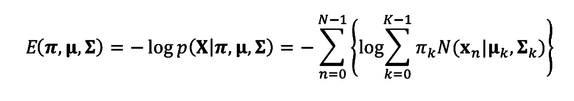

In [27]:
# 혼합 가우스의 목적 함수
def nlh_mixgauss(x, pi, mu, sigma):
    # x: NxD
    # pi: Kx1
    # mu: KxD
    # sigma: KxDxD
    # output lh: NxK
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
      y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    lh = 0
    for n in range(N):
      wk = 0
      for k in range(K):
        wk = wk + pi[k] * y[n, k]
      lh = lh + np.log(wk)
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


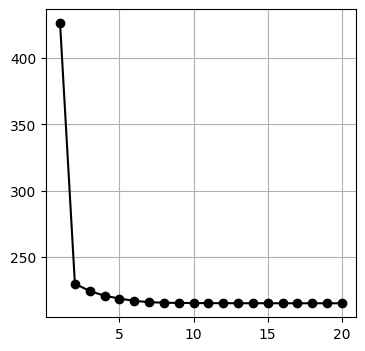

In [28]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]

max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it):
  Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
  Err[it] = nlh_mixgauss(X,Pi,Mu,Sigma)
  Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
Err, color='k', linestyle='-', marker='o')
#plt.ylim([40, 80])
plt.grid(True)
plt.show()

음의 로그 가능도는 점차 감소해 step10정도에서 대부분 수렴함.
음의 로그 가능도를 계산하는 알고리즘이 정상 작동, 반복 계산의 종료 조건으로 사용 가능.